In [1]:
import retinanalysis as ra
import importlib
import pandas as pd
import numpy as np
# import xarray as xr
display(ra.settings.mea_config)
import matplotlib.pyplot as plt
# ra.database_pop.reload_celltypefiles()
# ra.database_utils.populate_database()

[2025-07-09 11:13:23,854][INFO]: Connecting root@127.0.0.1:3306
[2025-07-09 11:13:23,970][INFO]: Connected root@127.0.0.1:3306


{'data': '/Volumes/data-1/data/sorted',
 'analysis': '/Volumes/data-1/analysis',
 'h5': '/Volumes/data-1/data/h5',
 'meta': '/Volumes/data-1/datajoint_testbed/mea/meta',
 'tags': '/Volumes/data-1/datajoint_testbed/mea/tags',
 'user': 'vyomr'}

In [2]:
df = ra.get_datasets_from_protocol_names('dots')
# df = ra.get_datasets_from_protocol_names('mat')
# df[df.exp_name=='20250514C']
df.head()


Found 1 protocols matching "dots":
['manookinlab.protocols.ObjectMotionDots']

Found 60 experiments, 107 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20230614C,data010,0.0,chunk2,manookinlab.protocols.ObjectMotionDots,1,20230614C/data010,OMS dots,2,13,19,19,2
1,20230713C,data030,2.0,chunk2,manookinlab.protocols.ObjectMotionDots,1,20230713C/data030,Mesopic OMS dots,4,13,62,67,6
2,20230713C,data031,0.0,chunk2,manookinlab.protocols.ObjectMotionDots,1,20230713C/data031,Photopic OMS dots,4,13,63,68,6
3,20230719C,data026,0.0,chunk3,manookinlab.protocols.ObjectMotionDots,1,20230719C/data026,oms dots,5,13,85,96,9
4,20230719C,data027,0.0,chunk3,manookinlab.protocols.ObjectMotionDots,1,20230719C/data027,oms dots,5,13,85,97,9


Finding typing files for unique experiments:  63%|██████▎   | 38/60 [00:09<00:04,  4.87it/s]

Error reading cell typing file /Volumes/data-1/analysis/20231026C/noise1K/kilosort2/classification.txt. Please check the file format.
Error reading cell typing file /Volumes/data-1/analysis/20231026C/noise1K/kilosort2/classification.txt. Please check the file format.
Error reading cell typing file /Volumes/data-1/analysis/20231026C/noise1K/kilosort2/classification.txt. Please check the file format.
Error reading cell typing file /Volumes/data-1/analysis/20231026C/noise1K/kilosort2/classification.txt. Please check the file format.


Finding typing files for unique experiments: 100%|██████████| 60/60 [00:14<00:00,  4.28it/s]

Found 23 datasets without any typing files:


,exp_name,datafile_name,nearest_noise_chunk,nearest_noise_distance
0,20220816C,data017,chunk2,26.000000
1,20220816C,data029,chunk3,27.666667
2,20220829C,data022,chunk3,5.783333
3,20221114C,data037,chunk5,4.866667
4,20230314C,data020,photopic_noise,-91.833333
5,20230314C,data031,chunk4,26.250000
6,20230320C,data009,noise1,46.850000
7,20230320C,data019,chunk2,55.400000
8,20230328C,data007,scotopic_noise,12.316667
9,20230328C,data008,noise1,16.966667


Found 197 datasets with typing files.
Found 57 unique datasets with typing files and > 0  cells of interest.
Error processing 20230516C, ['data013' 'data014'], chunk3: Not all epoch blocks used same number of X checks


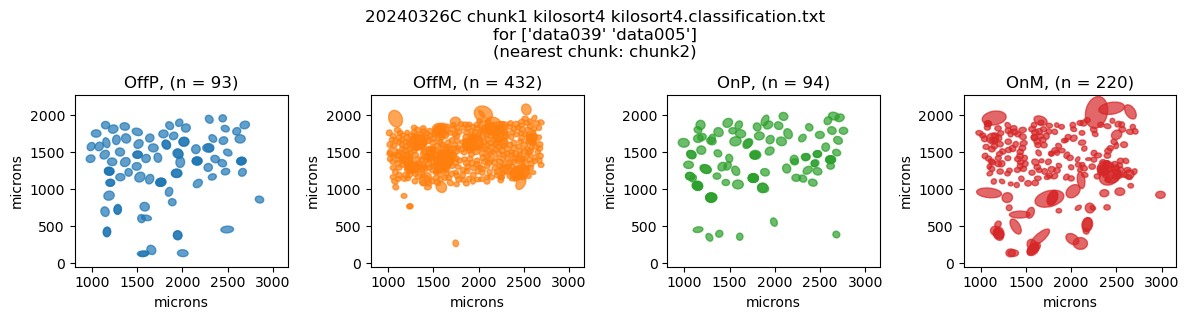

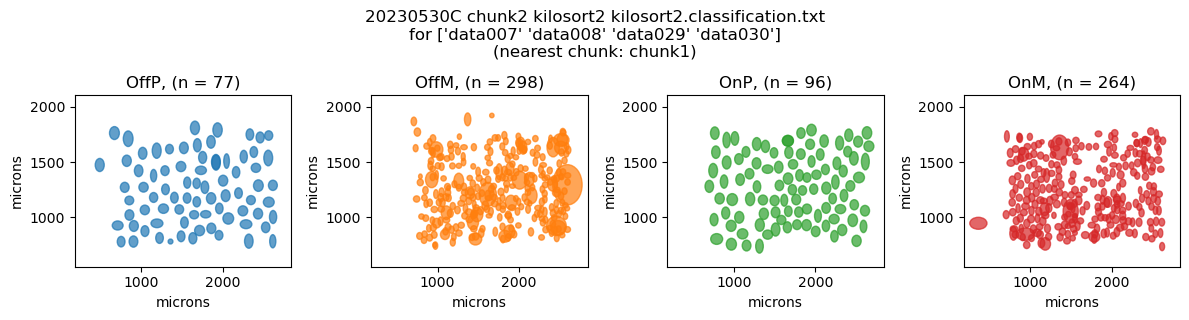

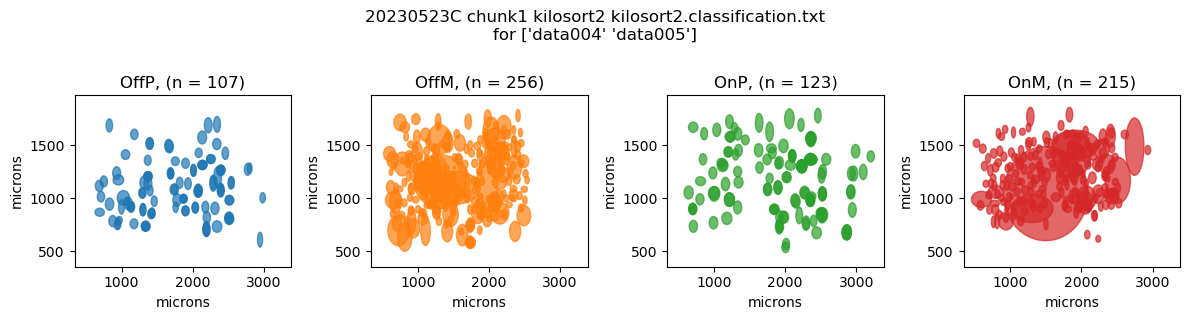

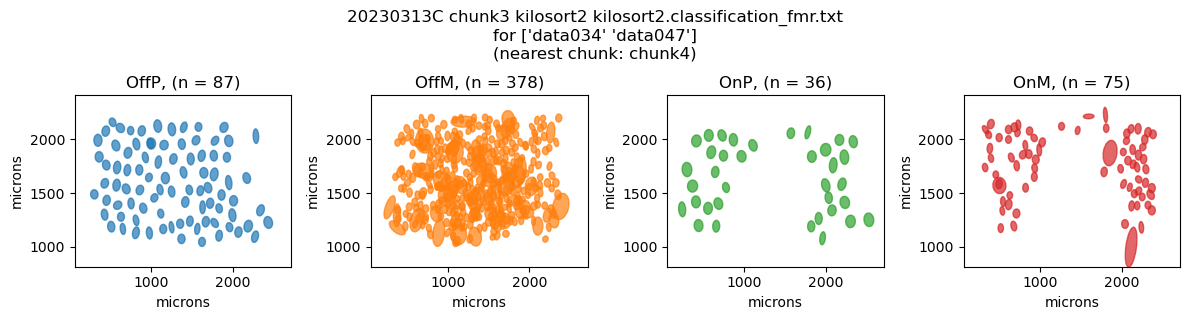

In [3]:
ls_cell_types = ['OffP', 'OffM', 'OnP', 'OnM']
df_typed, df_not_typed = ra.plot_mosaics_for_all_datasets(df, ls_cell_types, n_top=5)

In [ ]:
def plot_mosaics_for_all_datasets(df: pd.DataFrame, ls_cell_types: list=['OffP', 'OffM', 'OnP', 'OnM']):
    df_u = df[['exp_name', 'typed_noise_chunk']].drop_duplicates()
    print(f'Found {df_u.shape[0]} unique datasets with typing files.')
    for u_idx in df_u.index[:3]:
        exp_name = df_u.at[u_idx, 'exp_name']
        
        chunk_name = df_u.at[u_idx, 'typed_noise_chunk']
        df_q = df.query(f'exp_name == "{exp_name}" and typed_noise_chunk == "{chunk_name}"')
        df_q = df_q.reset_index(drop=True)
        datafile_names = df_q['datafile_name'].unique()
        # for i, row in df_q.iterrows():
        # Find row with max n_cells_of_interest
        row = df_q.loc[df_q['n_cells_of_interest'].idxmax()]
        n_cells_of_interest = row['n_cells_of_interest']
        ss_version = row['ss_version']
        typing_file = row['typing_file_name']
        try:    
            ac1 = anc.AnalysisChunk(exp_name, chunk_name, ss_version, b_load_spatial_maps=False,
                                include_ei=False, include_neurons=False, verbose=False)

            axs = ac1.plot_rfs(typing_file=typing_file,
                cell_types=ls_cell_types, units = 'microns', 
                std_scaling = 1.0, b_zoom=True, n_pad = 6
            )
            f = axs[0].get_figure()
            ideal_chunk = row['ideal_noise_chunk']
            str_title = f"{exp_name} {chunk_name} {ss_version} {typing_file}\nfor {datafile_names}"
            if ideal_chunk != chunk_name:
                str_title += f"\n(ideal chunk: {ideal_chunk})"
            f.suptitle(str_title, y=1.05)
            
            # Set aspect ratio to 1
            # f.constrained_layout = True
            # f.tight_layout()
            # for ax in axs:
            #     ax.set_aspect('equal')
            # Adjust horizontal spacing
            
            # 
        except Exception as e:
            print(f'Error processing {exp_name}, {datafile_names}, {chunk_name}: {e}')
            continue

test = plot_mosaics_for_all_datasets(df_with_cells)


In [ ]:
df_pi = ra.get_datasets_from_protocol_names('presentimages')

In [ ]:
# Get where group label lower contains leaves
df_pi.loc[60:]